In [41]:
from bs4 import BeautifulSoup
import requests
import time
import datetime
import pandas as pd
import random
import numpy as np

In [111]:
property_descriptions = [] #empty list to put the data in for the data frame 

#i'm going to randomly pick each time a header, to avoid getting blocked by the site
user_agents = [
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.82 Safari/537.36",
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36",
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.150 Safari/537.36"
]

page_number = 1

while True:
    url = f'https://www.willhaben.at/iad/immobilien/mietwohnungen/wien?page={page_number}'
    headers = {'User-Agent': random.choice(user_agents)}
    
    web_page = requests.get(url, headers=headers)
    
    if web_page.status_code == 200: #checking if the response was succesful
        soup = BeautifulSoup(web_page.content, 'html.parser')
        property_page = soup.find('div', class_='Box-sc-wfmb7k-0 sc-e6e65d9a-0 eCrUsU bRCDJD')
        
        if not property_page:
            print(f"No properties found on page {page_number}. Stopping.")
            break

        properties = property_page.find_all('div', class_='Box-sc-wfmb7k-0 khNDPc') #this is a grid where the properties are listed on the site

        if not properties:
            print(f"No more properties to process. Stopping at page {page_number}.")
            break
            
        # adding the x_elem to check if the element exist before inputing it into the df, if it does then N/A
        for property_ in properties:
            price_elem = property_.find('span', class_='Text-sc-10o2fdq-0 sc-b4c02c1e-3 hUgELZ iJcdrF')
            price = price_elem.text.strip() if price_elem else None
            
            details = property_.find_all('span', class_="Text-sc-10o2fdq-0 djYXLM")
            
            #surface and # of bedrooms share the same html code in each property box, 
            #so we check for all such instances and take the first and the second occurance
            #and interpret it as surface and number of bedrooms respectively
            
            surface = details[0].text.strip() if len(details) > 0 else None
            bedrooms = details[1].text.strip() if len(details) > 1 else None
            
            address_elem = property_.find('span', class_='Text-sc-10o2fdq-0 jqrIwa')
            address = address_elem.text.strip() if address_elem else None


            #addding scraped data to the list 
            property_descriptions.append({
                'address': address,
                'surface': surface,
                'bedrooms': bedrooms,
                'price': price
            })

        print(f'Page {page_number} processed.')
        page_number += 1  # Move to the next page
    else:
        print(f"Failed to retrieve page {page_number}. Status code: {web_page.status_code}")
        break

# Convert results to a DataFrame
df = pd.DataFrame(property_descriptions)
df.head()

Page 1 processed.
Page 2 processed.
Page 3 processed.
Page 4 processed.
Page 5 processed.
Page 6 processed.
Page 7 processed.
Page 8 processed.
Page 9 processed.
Page 10 processed.
Page 11 processed.
Page 12 processed.
Page 13 processed.
Page 14 processed.
Page 15 processed.
Page 16 processed.
Page 17 processed.
Page 18 processed.
Page 19 processed.
Page 20 processed.
Page 21 processed.
Page 22 processed.
Page 23 processed.
Page 24 processed.
Page 25 processed.
Page 26 processed.
Page 27 processed.
Page 28 processed.
Page 29 processed.
Page 30 processed.
Page 31 processed.
Page 32 processed.
Page 33 processed.
Page 34 processed.
Page 35 processed.
Page 36 processed.
Page 37 processed.
Page 38 processed.
Page 39 processed.
Page 40 processed.
Page 41 processed.
Page 42 processed.
Page 43 processed.
Page 44 processed.
Page 45 processed.
Page 46 processed.
Page 47 processed.
Page 48 processed.
Page 49 processed.
Page 50 processed.
Page 51 processed.
Page 52 processed.
Page 53 processed.
Pa

,address,surface,bedrooms,price
0,"1160 Wien, 16. Bezirk, Ottakring, Grundsteinga...",50,2,None
1,"1220 Wien, 22. Bezirk, Donaustadt, Alfred Pisc...",74,3,€ 1.200
2,"1220 Wien, 22. Bezirk, Donaustadt",37,2,"€ 803,03"
3,"1140 Wien, 14. Bezirk, Penzing",64,2,"€ 1.064,91"
4,"1140 Wien, 14. Bezirk, Penzing",64,2,"€ 1.083,59"


In [113]:
df.to_csv('vienna_homes_willhaben.csv', index=False)

In [115]:
df['price'] = df['price'].str.strip().str[1:]

In [117]:
df['price']= df['price'].str.replace('.', '')

In [119]:
df['price']= df['price'].str.replace(',', '.')
df['price']= pd.to_numeric(df['price'])

In [121]:
df['surface'] = pd.to_numeric(df['surface'], errors='coerce')
df['bedrooms'] = pd.to_numeric(df['bedrooms'], errors='coerce')

In [123]:
df.replace(np.inf, np.nan, inplace=True)
df.dropna(inplace= True)

In [125]:
df['district'] = df['address'].str.extract(r'(\d+)\. Bezirk')
df['district'] = pd.to_numeric(df['district'], errors= 'coerce')
df.head()

,address,surface,bedrooms,price,district
1,"1220 Wien, 22. Bezirk, Donaustadt, Alfred Pisc...",74.0,3.0,1200.00,22
2,"1220 Wien, 22. Bezirk, Donaustadt",37.0,2.0,803.03,22
3,"1140 Wien, 14. Bezirk, Penzing",64.0,2.0,1064.91,14
4,"1140 Wien, 14. Bezirk, Penzing",64.0,2.0,1083.59,14
5,"1210 Wien, 21. Bezirk, Floridsdorf",100.0,4.0,2155.00,21


In [127]:
df['price_per_sq_meter'] = df['price'] / df['surface']
df.head()

,address,surface,bedrooms,price,district,price_per_sq_meter
1,"1220 Wien, 22. Bezirk, Donaustadt, Alfred Pisc...",74.0,3.0,1200.00,22,16.216216
2,"1220 Wien, 22. Bezirk, Donaustadt",37.0,2.0,803.03,22,21.703514
3,"1140 Wien, 14. Bezirk, Penzing",64.0,2.0,1064.91,14,16.639219
4,"1140 Wien, 14. Bezirk, Penzing",64.0,2.0,1083.59,14,16.931094
5,"1210 Wien, 21. Bezirk, Floridsdorf",100.0,4.0,2155.00,21,21.550000


In [129]:
df.dtypes

address                object
surface               float64
bedrooms              float64
price                 float64
district                int64
price_per_sq_meter    float64
dtype: object

In [131]:
df.describe()

,surface,bedrooms,price,district,price_per_sq_meter
count,693.000000,693.000000,693.000000,693.000000,693.000000
mean,73.246753,2.548341,1471.653391,14.520924,20.296117
std,37.746623,0.967410,948.346274,7.048444,7.536526
min,13.000000,1.000000,1.000000,1.000000,0.012821
25%,48.000000,2.000000,899.000000,10.000000,16.639219
50%,61.000000,2.000000,1199.000000,14.000000,19.239130
75%,86.000000,3.000000,1649.000000,22.000000,22.267636
max,262.000000,8.000000,9709.720000,23.000000,116.785714


In [133]:
df.to_csv('clean_vienna_homes_willhaben.csv', index=False)

In [135]:
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [153]:
import plotly.io as pio
import plotly.express as px

In [137]:
district_mean_price_per_sq = pd.pivot_table(df, index=['district'], aggfunc={'price_per_sq_meter': 'median'})
district_mean_price_per_sq

,price_per_sq_meter
district,
1,22.799409
2,23.980000
3,20.878931
4,17.825753
5,20.050170
6,19.016667
7,23.795196
8,17.752287
9,22.362394


In [139]:
vienna = gpd.read_file(r'C:\Users\andre\Python Projects\vienna_.geojson')
vienna.head()

C:\Anaconda\Lib\site-packages\geopandas\io\file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
C:\Anaconda\Lib\site-packages\geopandas\io\file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")


,name,cartodb_id,created_at,updated_at,geometry
0,Josefstadt,1,2013-11-29 19:08:42+01:00,2013-11-29 19:08:42+01:00,"MULTIPOLYGON (((16.34915 48.21516, 16.35099 48..."
1,Alsergrund,2,2013-11-29 19:08:42+01:00,2013-11-29 19:08:42+01:00,"MULTIPOLYGON (((16.36165 48.23192, 16.36166 48..."
2,Favoriten,3,2013-11-29 19:08:42+01:00,2013-11-29 19:08:42+01:00,"MULTIPOLYGON (((16.38382 48.18516, 16.38404 48..."
3,Simmering,4,2013-11-29 19:08:42+01:00,2013-11-29 19:08:42+01:00,"MULTIPOLYGON (((16.42520 48.18575, 16.42604 48..."
4,Meidling,5,2013-11-29 19:08:42+01:00,2013-11-29 19:08:42+01:00,"MULTIPOLYGON (((16.34174 48.18847, 16.34184 48..."


In [141]:
correct_district_numbers=pd.read_csv(r'C:\Users\andre\Downloads\vienna districts - Sheet1.csv')
correct_district_numbers.head()

,districts,distric_name
0,1,Innere Stadt
1,2,Leopoldstadt
2,3,Landstraße
3,4,Wieden
4,5,Margareten


In [143]:
vienna_complete= pd.merge(vienna, 
                          district_mean_price_per_sq.merge(correct_district_numbers, how='outer', left_on= 'district', right_on= 'districts'), 
                          how='outer', left_on='name', right_on='distric_name')
vienna_complete.head()

,name,cartodb_id,created_at,updated_at,geometry,price_per_sq_meter,districts,distric_name
0,Alsergrund,2,2013-11-29 19:08:42+01:00,2013-11-29 19:08:42+01:00,"MULTIPOLYGON (((16.36165 48.23192, 16.36166 48...",22.362394,9,Alsergrund
1,Brigittenau,19,2013-11-29 19:08:42+01:00,2013-11-29 19:08:42+01:00,"MULTIPOLYGON (((16.37361 48.26127, 16.37734 48...",19.042766,20,Brigittenau
2,Donaustadt,21,2013-11-29 19:08:42+01:00,2013-11-29 19:08:42+01:00,"MULTIPOLYGON (((16.50784 48.27345, 16.50903 48...",19.769918,22,Donaustadt
3,Döbling,18,2013-11-29 19:08:42+01:00,2013-11-29 19:13:26+01:00,"MULTIPOLYGON (((16.35681 48.28229, 16.35803 48...",19.384694,19,Döbling
4,Favoriten,3,2013-11-29 19:08:42+01:00,2013-11-29 19:08:42+01:00,"MULTIPOLYGON (((16.38382 48.18516, 16.38404 48...",16.968209,10,Favoriten


In [145]:
vienna_complete.drop('distric_name', axis=1, inplace= True)
vienna_complete.rename(columns= {'districts': 'district_code'}, inplace=True)
vienna_complete.head()

,name,cartodb_id,created_at,updated_at,geometry,price_per_sq_meter,district_code
0,Alsergrund,2,2013-11-29 19:08:42+01:00,2013-11-29 19:08:42+01:00,"MULTIPOLYGON (((16.36165 48.23192, 16.36166 48...",22.362394,9
1,Brigittenau,19,2013-11-29 19:08:42+01:00,2013-11-29 19:08:42+01:00,"MULTIPOLYGON (((16.37361 48.26127, 16.37734 48...",19.042766,20
2,Donaustadt,21,2013-11-29 19:08:42+01:00,2013-11-29 19:08:42+01:00,"MULTIPOLYGON (((16.50784 48.27345, 16.50903 48...",19.769918,22
3,Döbling,18,2013-11-29 19:08:42+01:00,2013-11-29 19:13:26+01:00,"MULTIPOLYGON (((16.35681 48.28229, 16.35803 48...",19.384694,19
4,Favoriten,3,2013-11-29 19:08:42+01:00,2013-11-29 19:08:42+01:00,"MULTIPOLYGON (((16.38382 48.18516, 16.38404 48...",16.968209,10


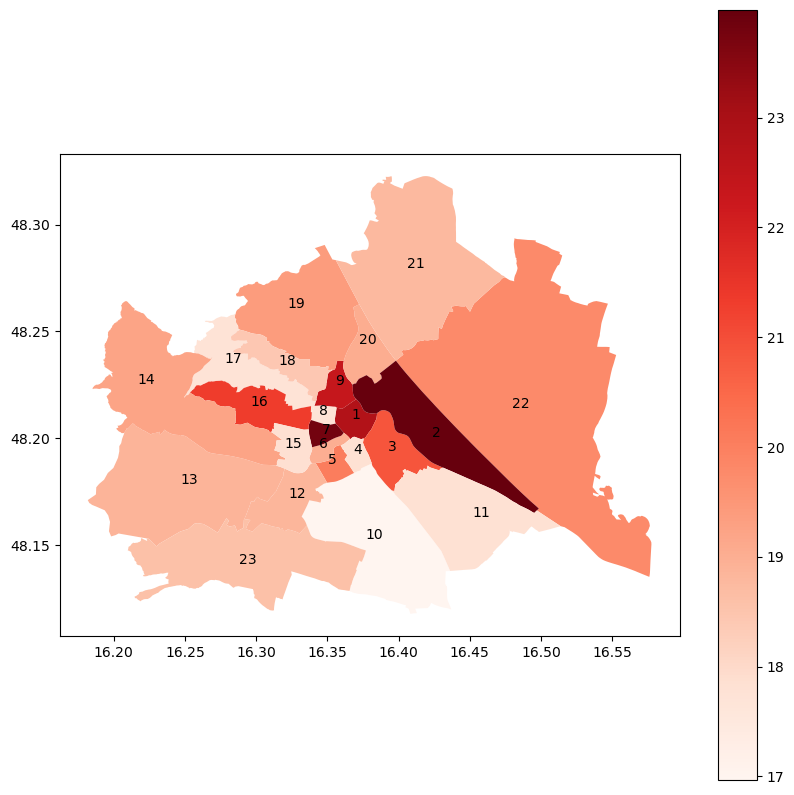

In [157]:
vienna_complete['coords'] = vienna_complete['geometry'].apply(lambda x: x.representative_point().coords[:])

vienna_complete['coords'] = [coords[0] for coords in vienna_complete['coords']]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()

vienna_complete.plot(column='price_per_sq_meter', ax=ax, cmap='Reds', legend=True)

for idx, row in vienna_complete.iterrows():
    plt.annotate(text=row['district_code'], xy=row['coords'], horizontalalignment='center', color='black')

In [163]:
vienna_complete.drop('coords', axis=1).to_file("vienna_districts_mean_price.json", driver="GeoJSON")

In [165]:
pd.pivot_table(df, index=['district'], aggfunc={'price_per_sq_meter': 'count'})

,price_per_sq_meter
district,
1,30
2,21
3,26
4,18
5,10
6,12
7,11
8,6
9,29
